In [1]:
import torch_geometric.transforms as T
import os.path as osp
from torch_geometric.datasets import Planetoid
from sklearn.manifold import TSNE
import torch
import umap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib.patches import Ellipse
import seaborn as sns
import plotly.express as px

import scipy.sparse
import scipy.sparse.linalg

2024-08-09 15:48:15.572946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 15:48:16.162090: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 15:48:16.169295: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-09 15:48:16.169321: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# Calculate the area between ROC and y=x line

def compute_area_above_below_curve(x, y):
    area_above = 0.0
    area_below = 0.0
    
    for i in range(1, len(x)):
        x0, x1 = x[i - 1], x[i]
        y0, y1 = y[i - 1], y[i]
        line0, line1 = x0, x1  # Since line y = x
        
        if y1 == y0:  # Vertical segment
            if y0 > x0:
                area_above += (y0 - x0) * (x1 - x0)
            else:
                area_below += (x0 - y0) * (x1 - x0)
            continue
        
        # Find intersection with y = x
        if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
            if y0 >= x0 and y1 >= x1:
                area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
            else:
                area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
        else:
            x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < x0:
                area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
            else:
                area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
    return area_above, area_below



In [3]:
from torch_geometric.datasets import CitationFull
dataset = CitationFull(root='/tmp/CitationFull', name='Cora_ML')
# Cora_ML, 2,995 nodes, 16,316 edges, 7 classes


data = dataset[0]
# access data x
edges = data.edge_index
# turn this into a sparse matrix
obs_adj = torch.sparse_coo_tensor(edges, torch.ones(edges.shape[1]), (data.num_nodes, data.num_nodes))
obs_adj
# dense version
As = obs_adj.to_dense().numpy()

tau = data.y.numpy()
# choose d
d=7

In [4]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

k = 3
B = 1

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(As.astype(float), d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

100%|██████████| 1/1 [00:22<00:00, 22.80s/it]


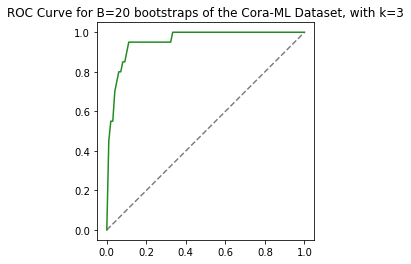

Total area (above and below y=x): 0.4601469237832873 for k=3


In [14]:
# Provided code
p_hat_list = p_vals
roc = []
alphas = []

for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for B={B} bootstraps of the Cora-ML Dataset, with k={k}")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# Find the area between the ROC curve and the y=x line
x = np.linspace(0, 1, 100)
roc_interpolated = np.interp(x, alphas, roc)

# Compute areas
area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
total_area = area_above + area_below

print(f"Total area (above and below y=x): {total_area} for k={k}")

In [5]:
A_list = [As.astype(float)] + A_boots_list
len(A_list)

# yhat = UASE(A_list, d=d, sparse_matrix=False)

2

/home/uj21900/anaconda3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


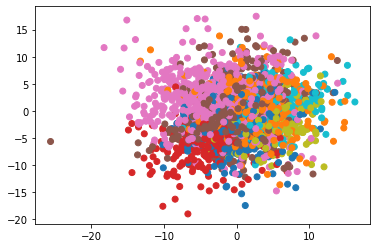

In [6]:
y_obs = unfolded_n2v(np.array([A_list[0]]), 10)

plt.figure()
plt.scatter(y_obs[:, 0], y_obs[:, 1], c=tau, cmap='tab10')

In [67]:
# from copy import deepcopy

# def degree_correction(X):
#     """
#     Perform degree correction.

#     Parameters
#     ----------
#     X : numpy.ndarray
#         The embedding of the graph.

#     Returns
#     -------
#     Y : numpy.ndarray
#         The degree-corrected embedding.
#     """
#     tol = 1e-12
#     Y = deepcopy(X)
#     norms = np.linalg.norm(X, axis=1)
#     idx = np.where(norms > tol)
#     Y[idx] = X[idx] / (norms[idx, None])
#     return Y

# y_obs = degree_correction(y_obs)

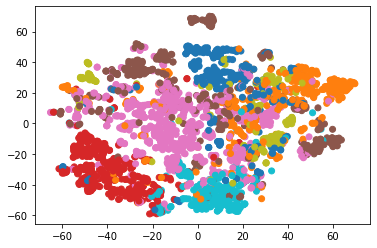

In [7]:
tsne_obs = TSNE(n_components=2).fit_transform(y_obs)

plt.figure()
plt.scatter(tsne_obs[:, 0], tsne_obs[:, 1], c=tau, cmap='tab10')

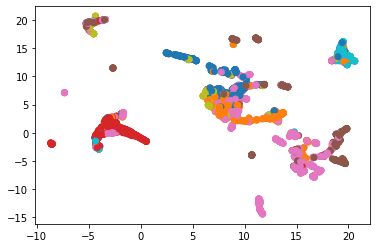

In [69]:
umap_obs = UMAP(n_components=2).fit_transform(y_obs)

plt.figure()
plt.scatter(umap_obs[:, 0], umap_obs[:, 1], c=tau, cmap='tab10')

In [16]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = (tau.tolist())*(B+1)

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(tau))

In [17]:
fig = px.scatter(yadf, 
                 x='Dimension_1', 
                 y='Dimension_2', 
                 color='tau', 
                 animation_frame='Matrix')
fig.show()

In [18]:
# tsne this embedding
tsne = TSNE(n_components=2, perplexity=30, random_state=0)

yhat_tsne = tsne.fit_transform(yhat)

In [20]:
yhat_tsne_df = pd.DataFrame(yhat_tsne, columns=["Dimension_1", "Dimension_2"])

# add column for the matrix it is
yhat_tsne_df["Matrix"] = np.repeat(range(B+1), len(tau))
# repeats tau list the len of A_true_boots_list times
yhat_tsne_df["tau"] = (tau.tolist()*(B+1))

yhat_tsne_df0 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 0]
yhat_tsne_df1 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 1]

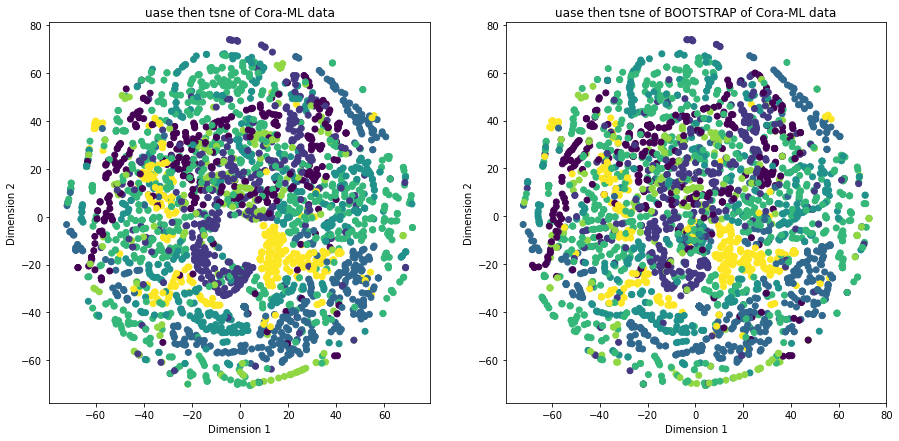

In [44]:
# plot two figures for the two different dfs side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# plot the first df
scatter = ax1.scatter(yhat_tsne_df0["Dimension_1"], yhat_tsne_df0["Dimension_2"], c=yhat_tsne_df0["tau"], cmap='viridis')
ax1.set_title("uase then tsne of Cora-ML data")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")

# plot the second df
scatter = ax2.scatter(yhat_tsne_df1["Dimension_1"], yhat_tsne_df1["Dimension_2"], c=yhat_tsne_df1["tau"], cmap='viridis')
ax2.set_title("uase then tsne of BOOTSTRAP of Cora-ML data")
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")

# plt.colorbar(scatter)
plt.show()

In [43]:
# umap this embedding
umap = umap.UMAP(n_components=2, random_state=0)

yhat_umap = umap.fit_transform(yhat)

In [46]:
yhat_umap_df = pd.DataFrame(yhat_umap, columns=["Dimension_1", "Dimension_2"])

# add column for the matrix it is
yhat_umap_df["Matrix"] = np.repeat(range(B+1), len(tau))
# repeats tau list the len of A_true_boots_list times
yhat_umap_df["tau"] = (tau.tolist()*(B+1))

yhat_umap_df0 = yhat_umap_df[yhat_umap_df["Matrix"] == 0]
yhat_umap_df1 = yhat_umap_df[yhat_umap_df["Matrix"] == 1]

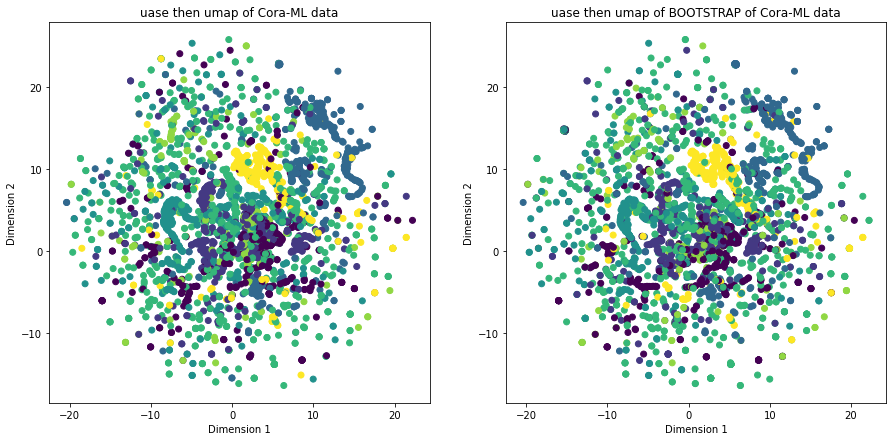

In [47]:
# plot two figures for the two different dfs side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# plot the first df
scatter = ax1.scatter(yhat_umap_df0["Dimension_1"], yhat_umap_df0["Dimension_2"], c=yhat_umap_df0["tau"], cmap='viridis')
ax1.set_title("uase then umap of Cora-ML data")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")

# plot the second df
scatter = ax2.scatter(yhat_umap_df1["Dimension_1"], yhat_umap_df1["Dimension_2"], c=yhat_umap_df1["tau"], cmap='viridis')
ax2.set_title("uase then umap of BOOTSTRAP of Cora-ML data")
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")

# plt.colorbar(scatter)
plt.show()